# MNIST Inpainting con imagen de referencia
En este experimento se implementará y entrenará un modelo de image inpainting sobre el dataset de MNIST. Se entrenará un modelo capaz de regenerar secciones faltantes dentro de imágenes de MNIST de forma realista. El modelo consiste de Deep Convolutional Networks, y se entrenará mediante un framework GAN, es decir, se entrenará un modelo generador y un discriminador en simultaneo.

En esta primera versión, el generador solo recibe la imágen con la sección a ser regenerada. En otro experimento se buscará pasar una segunda imágen de referencia al modelo.

## Imports y setup

In [1]:
# to generate gifs
!pip install imageio

In [2]:
import tensorflow as tf
tf.enable_eager_execution()

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import time

from IPython import display

## Carga del dataset

Usaremos el dataset de MNIST para entrenar al generador y al discriminador, el cual viene incluido dentro de la API de tf.keras. El dataset es dividido en dos para el entrenamiento: una mitad se utilizará como imágenes reales para entrenar al discriminador, y a la otra mitad se le aplicará una mascara para ocultar una región, la cual deberá ser regenerada por el generador.

In [3]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
print(train_images.shape)
print(train_labels.shape)

(60000, 28, 28)
(60000,)


In [4]:
def mask(image, reference_image):
  """
  Applies a mask of zeroes of size 7x7 at the center of the image.
  Returns a tuple of the masked image and the original image.
  """
  upper_edge = tf.ones([10,28,1], tf.float32)
  lower_edge = tf.ones([11,28,1], tf.float32)
  
  middle_left = tf.ones([7,10,1], tf.float32)
  middle_right = tf.ones([7,11,1], tf.float32)
  
  zeros = tf.zeros([7,7,1], tf.float32)
  
  middle = tf.concat([middle_left, zeros, middle_right], axis=1)
  mask = tf.concat([upper_edge, middle, lower_edge], axis=0)
  
  return (image * mask, image, reference_image)
  

### Training set

In [5]:
def create_reference_dictionary(reference_labels):
  reference_dict = {}
  for label in range(10):
    reference_dict[label] = np.where(train_reference_labels == label)[0]
  return reference_dict

In [6]:
def get_references(reference_pool, labels, reference_dict):
  reference_images = []
  for label in labels:
    reference_idx = np.random.choice(reference_dict[label])
    reference_images.append(reference_pool[reference_idx])
  return np.array(reference_images)

In [7]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')

# Normalize the images to [-1, 1]
train_images = (train_images - 127.5) / 127.5
test_images = (test_images - 127.5) / 127.5

indeces = np.random.permutation(len(train_images))
train_images = train_images[indeces]
train_labels = train_labels[indeces]

# Split between training and validation sets
TRAINING_SAMPLES = int(len(train_images) * 0.9)
train_set_images = train_images[:TRAINING_SAMPLES,:,:,:]
validation_set_images = train_images[TRAINING_SAMPLES:,:,:,:]

# TODO: generar diccionario de referencias para validation.

train_set_labels = train_labels[:TRAINING_SAMPLES]
validation_set_labels = train_labels[TRAINING_SAMPLES:]

# Split training images between masked and full images.
REAL_IMAGES_BOUNDRY = int(len(train_set_images) * 0.4)
MASKED_IMAGES_BOUNDRY = REAL_IMAGES_BOUNDRY + int(len(train_set_images) * 0.4)

train_full_images = train_set_images[:REAL_IMAGES_BOUNDRY,:,:,:]
train_masked_images = train_set_images[REAL_IMAGES_BOUNDRY:MASKED_IMAGES_BOUNDRY,:,:,:]
train_reference_images = train_set_images[MASKED_IMAGES_BOUNDRY:,:,:,:]

train_full_labels = train_set_labels[:REAL_IMAGES_BOUNDRY]
train_masked_labels = train_set_labels[REAL_IMAGES_BOUNDRY:MASKED_IMAGES_BOUNDRY]
train_reference_labels = train_set_labels[MASKED_IMAGES_BOUNDRY:]


train_reference_dict = create_reference_dictionary(train_reference_labels)
train_full_references = get_references(train_reference_images, train_full_labels, train_reference_dict)
train_masked_references = get_references(train_reference_images, train_masked_labels, train_reference_dict)


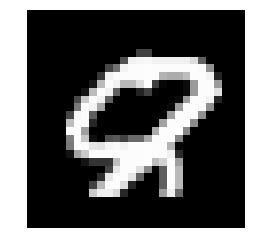

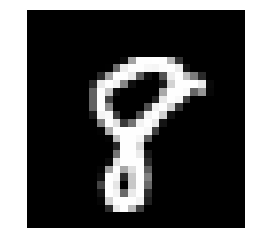

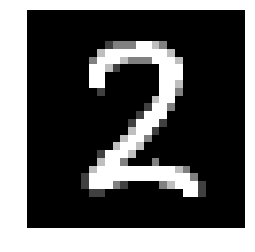

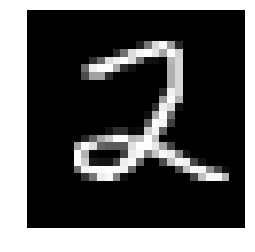

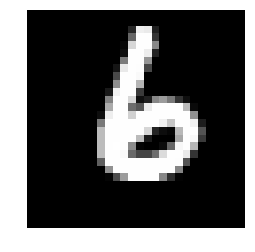

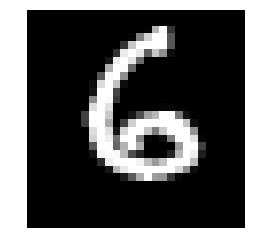

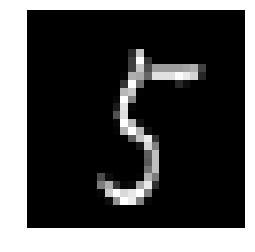

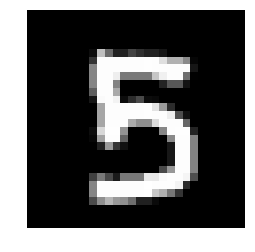

In [8]:
for i in range(4):
  plt.imshow(train_masked_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
  plt.axis('off')
  plt.show()
  plt.imshow(train_masked_references[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
  plt.axis('off')
  plt.show()

In [9]:
BUFFER_SIZE = TRAINING_SAMPLES
BATCH_SIZE = 256

train_full_images_ds = tf.data.Dataset.from_tensor_slices((train_full_images, train_full_references)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_masked_images_ds = tf.data.Dataset.from_tensor_slices((train_masked_images, train_masked_references)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).map(mask)

train_dataset = tf.data.Dataset.zip((train_full_images_ds, train_masked_images_ds))

### Validation set

In [ ]:
def show_and_save_images(images, name):
  fig = plt.figure(figsize=(4,4))
  
  for i in range(images.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
        
  plt.savefig(name)
  plt.show()

In [ ]:
# Save a subset of images for validation
np.random.shuffle(validation_set_images)
validation_images = validation_set_images[:16]

validation_masked_images = []
for image in validation_images:
  masked_image, _ = mask(image)
  validation_masked_images.append(masked_image.numpy())

validation_masked_images = np.array(validation_masked_images)

show_and_save_images(validation_masked_images, 'validation_masked_images.png')
show_and_save_images(validation_images, 'validation_unmasked_images.png')

## Creación de los modelos

### Generador

El objetivo del generador es regenerar las secciones faltantes en las imágenes enmascaradas de forma realista. La arquitectura del generador consiste de un modelo Encoder-Decoder. El Encoder recibe la imágen con la región faltante, y aplica 3 capas convolucionales . El resultado del Encoder luego se pasa al Decoder. El Decoder aplica 3 capas convolucionales transpuestas hasta generar una imágen del tamaño de la región faltante. Esta imágen será el output del generator. Todas las capas convolucionales utilizan Batch Normalization y función de activación Leaky ReLU.

In [10]:
class Generator(tf.keras.Model):
  def __init__(self):
    super(Generator, self).__init__()
    
    # Masked encoder
    self.mask_enc_conv_1 = tf.keras.layers.Conv2D(64, (5, 5),
                                                  strides=(1, 1), 
                                                  padding='same', 
                                                  input_shape=(28, 28, 1))
    self.mask_enc_bn_1 = tf.keras.layers.BatchNormalization()
    self.mask_enc_act_1 = tf.keras.layers.LeakyReLU()
    # 28x28x64
    
    self.mask_enc_conv_2 = tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')
    self.mask_enc_bn_2 = tf.keras.layers.BatchNormalization()
    self.mask_enc_act_2 = tf.keras.layers.LeakyReLU()
    # 14x14x64
        
    self.mask_enc_conv_3 = tf.keras.layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same')
    self.mask_enc_bn_3 = tf.keras.layers.BatchNormalization()
    self.mask_enc_act_3 = tf.keras.layers.LeakyReLU()
    # 7x7x128

    
    # Reference encoder
    self.ref_enc_conv_1 = tf.keras.layers.Conv2D(64, (5, 5), 
                                                 strides=(1, 1), 
                                                 padding='same', 
                                                 input_shape=(28, 28, 1))
    self.ref_enc_bn_1 = tf.keras.layers.BatchNormalization()
    self.ref_enc_act_1 = tf.keras.layers.LeakyReLU()
    # 28x28x64
    
    self.ref_enc_conv_2 = tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')
    self.ref_enc_bn_2 = tf.keras.layers.BatchNormalization()
    self.ref_enc_act_2 = tf.keras.layers.LeakyReLU()
    # 14x14x64
        
    self.ref_enc_conv_3 = tf.keras.layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same')
    self.ref_enc_bn_3 = tf.keras.layers.BatchNormalization()
    self.ref_enc_act_3 = tf.keras.layers.LeakyReLU()
    # 7x7x128
    
    
    # Decoder
    self.dec_conv_1 = tf.keras.layers.Conv2DTranspose(128, (5, 5), 
                                                      strides=(1, 1), 
                                                      padding='same', 
                                                      use_bias=False, 
                                                      input_shape=(7, 7, 256))
    self.dec_bn_1 = tf.keras.layers.BatchNormalization()
    self.dec_act_1 = tf.keras.layers.LeakyReLU()
    # 7x7x128

    self.dec_conv_2 = tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(1, 1), padding='same', use_bias=False)
    self.dec_bn_2 = tf.keras.layers.BatchNormalization()
    self.dec_act_2 = tf.keras.layers.LeakyReLU()
    # 7x7x64
    
    self.dec_conv_3 = tf.keras.layers.Conv2DTranspose(1, (5, 5), 
                                                      strides=(1, 1), 
                                                      padding='same', 
                                                      use_bias=False, 
                                                      activation='tanh')
    # 7x7x1

  def call(self, inputs, training=True):
    
    masked_image = inputs[0]
    reference_image = inputs[1]
    
    # Apply masked image encoder
    masked_encoding = self.mask_enc_conv_1(masked_image)
    masked_encoding = self.mask_enc_bn_1(masked_encoding, training=training)
    masked_encoding = self.mask_enc_act_1(masked_encoding)
        
    masked_encoding = self.mask_enc_conv_2(masked_encoding)
    masked_encoding = self.mask_enc_bn_2(masked_encoding, training=training)
    masked_encoding = self.mask_enc_act_2(masked_encoding)
        
    masked_encoding = self.mask_enc_conv_3(masked_encoding)
    masked_encoding = self.mask_enc_bn_3(masked_encoding, training=training)
    masked_encoding = self.mask_enc_act_3(masked_encoding)
        
    # Apply reference image encoder
    reference_encoding = self.mask_enc_conv_1(reference_image)
    reference_encoding = self.mask_enc_bn_1(reference_encoding, training=training)
    reference_encoding = self.mask_enc_act_1(reference_encoding)
        
    reference_encoding = self.mask_enc_conv_2(reference_encoding)
    reference_encoding = self.mask_enc_bn_2(reference_encoding, training=training)
    reference_encoding = self.mask_enc_act_2(reference_encoding)
        
    reference_encoding = self.mask_enc_conv_3(reference_encoding)
    reference_encoding = self.mask_enc_bn_3(reference_encoding, training=training)
    reference_encoding = self.mask_enc_act_3(reference_encoding)
    
    # Join both the masked and reference encoding
    encoding = tf.concat([masked_encoding, reference_encoding], axis=-1)
    
    # Apply the decoder to the joined encoding
    encoding = self.dec_conv_1(encoding)
    encoding = self.dec_bn_1(encoding, training=training)
    encoding = self.dec_act_1(encoding)
        
    encoding = self.dec_conv_2(encoding)
    encoding = self.dec_bn_2(encoding, training=training)
    encoding = self.dec_act_2(encoding)
    
    generated_patch = self.dec_conv_3(encoding)
    
    return generated_patch

In [ ]:
def make_generator_encoder_model():
  model = tf.keras.Sequential()

  # Encoder
  model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(1, 1), padding='same', input_shape=(28, 28, 1)))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU())
  assert model.output_shape == (None, 28, 28, 64)

  model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU())
  assert model.output_shape == (None, 14, 14, 64)

  model.add(tf.keras.layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU())
  assert model.output_shape == (None, 7, 7, 128)

  return model

In [ ]:
def make_generator_decoder_model():
  model = tf.keras.Sequential()
  
  # Decoder  
  model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False, input_shape=(7, 7, 256)))
  assert model.output_shape == (None, 7, 7, 128)  
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU())

  model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(1, 1), padding='same', use_bias=False))
  assert model.output_shape == (None, 7, 7, 64)    
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU())

  model.add(tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
  assert model.output_shape == (None, 7, 7, 1)

  return model

### Discriminador

El objetivo del discriminador es distinguir entre imágenes reales e imágenes regeneradas por el generador. El discriminador recibe como entrada una imágen de 28x28. Luego se aplican dos capas convolucionales sobre la imágen, y finalmente se aplica una capa fully-connected de una neurona para determinar si la imágen es real o falsa. Entre cada capa se utiliza Dropout y la función de activación Leaky ReLU.

In [11]:
class Discriminator(tf.keras.Model):
  def __init__(self):
    super(Discriminator, self).__init__()
    
    # Image encoder
    self.img_enc_conv_1 = tf.keras.layers.Conv2D(64, (5, 5), 
                                                 strides=(2, 2), 
                                                 padding='same', 
                                                 input_shape=(28, 28, 1),
                                                 activation=tf.nn.leaky_relu)
    self.img_enc_drop_1 = tf.keras.layers.Dropout(0.3)
    # 14x14x64
      
    self.img_enc_conv_2 = tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', activation=tf.nn.leaky_relu)
    self.img_enc_drop_2 = tf.keras.layers.Dropout(0.3)
    # 7x7x128
     
    self.img_enc_flat = tf.keras.layers.Flatten()
    
    
    # Reference encoder
    self.ref_enc_conv_1 = tf.keras.layers.Conv2D(64, (5, 5), 
                                                 strides=(2, 2), 
                                                 padding='same', 
                                                 input_shape=(28, 28, 1),
                                                 activation=tf.nn.leaky_relu)
    self.ref_enc_drop_1 = tf.keras.layers.Dropout(0.3)
    # 14x14x64
      
    self.ref_enc_conv_2 = tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', activation=tf.nn.leaky_relu)
    self.ref_enc_drop_2 = tf.keras.layers.Dropout(0.3)
    # 7x7x128
     
    self.ref_enc_flat = tf.keras.layers.Flatten()
    
    
    # Classifier
    self.class_fc_1 = tf.keras.layers.Dense(1024, activation=tf.nn.leaky_relu)
    self.class_fc_2 = tf.keras.layers.Dense(1)
        

  def call(self, inputs, training=True):
    
    image = inputs[0]
    reference = inputs[1]
    
    # Apply masked image encoder
    img_encoding = self.img_enc_conv_1(image)
    img_encoding = self.img_enc_drop_1(img_encoding)
    
    img_encoding = self.img_enc_conv_2(img_encoding)
    img_encoding = self.img_enc_drop_2(img_encoding)
    
    img_encoding = self.img_enc_flat(img_encoding)
        
    # Apply reference image encoder
    ref_encoding = self.ref_enc_conv_1(reference)
    ref_encoding = self.ref_enc_drop_1(ref_encoding)
    
    ref_encoding = self.ref_enc_conv_2(ref_encoding)
    ref_encoding = self.ref_enc_drop_2(ref_encoding)
    
    ref_encoding = self.ref_enc_flat(ref_encoding)
        

    # Join both the image and reference encoding
    encoding = tf.concat([img_encoding, ref_encoding], axis=1)
    
    # Apply the classifier to the joined encoding
    encoding = self.class_fc_1(encoding)
    logits = self.class_fc_2(encoding)
    
    return logits

In [ ]:
def make_discriminator_encoder_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(28, 28, 1)))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
      
    model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
     
    model.add(tf.keras.layers.Flatten())
  
    return model

In [ ]:
def make_discriminator_classifier():
  model = tf.keras.Sequential()
  
  model.add(tf.keras.layers.Dense(1024, activation=tf.nn.leaky_relu))
  model.add(tf.keras.layers.Dense(1))

  return model

In [12]:
generator = Generator()
discriminator = Discriminator()

## Funciones de costo y optimizadores

A continuación se definen las funciones de costo para ambos modelos, y los optimizadores a utilizar para minimizar dichas funciones.

### Función de costo del generador
La función de costo del generador consiste de una función de Sigmoid Cross Entropy sobre las imágenes generadas. Se busca que la salida del discriminador sea 1 (reales) para dichas imágenes.

In [13]:
def generator_loss(generated_output):
    return tf.losses.sigmoid_cross_entropy(tf.ones_like(generated_output), generated_output)

### Función de costo del discriminador

La función de costo del discriminador tiene dos partes:
1. Costo sobre imágenes reales: consiste de una Sigmoid Cross Entropy sobre las imágenes reales. Se busca que la salida del discriminador sea 1 (reales) para dichas imágenes.
2. Costo sobre imágenes generadas: consiste de una Sigmoid Cross Entropy sobre las imágenes generadas por el generador. Se busca que la salida del discriminador sea 0 (falsas) para dichas imágenes.

Luego se suman estas dos funciones para obtener la función de costo del discriminador.

In [14]:
def discriminator_loss(real_output, generated_output):
    real_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=tf.ones_like(real_output), logits=real_output)
    generated_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=tf.zeros_like(generated_output), logits=generated_output)
    total_loss = real_loss + generated_loss
    return total_loss

### Optimizadores
Se utiliza un optimizador Adam para cada modelo, ya que estos se entrenan en paralelo.

In [15]:
generator_optimizer = tf.train.AdamOptimizer(1e-4)
discriminator_optimizer = tf.train.AdamOptimizer(1e-4)

## Checkpoints
Los parámetros de ambos modelos se almacenarán como checkpoints durante el entrenamiento, para poder recuperarlos luego.

In [16]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Configuración del entrenamiento

### Ejemplos de validación
Se mantendrá un conjunto de imágenes de validacion para visualizar los resultados del generador a lo largo del entrenamiento.

### Paso de entrenamiento

En cada paso del entrenamiento, el generador recibe un batch de imágenes enmascaradas, y regenera las secciones faltantes. Estas regiones generadas son luego insertadas en las imágenes del batch, completando las secciones faltantes con las regiones generadas por el generador. Luego, el discriminador recibe tanto estas imágenes con las secciones regeneradas, como imágenes reales.

Luego, en base a los resultados del discriminador, se calculan las funciones de costo de ambos modelos. Y finalmente, se aplica un paso de los optimizadores para cada modelo.

In [17]:
def patch_image(patch, image):
  """
  Apply the given patch to the image.
  The patch is applied at the center of the image, assuming a 7x7 patch and a 28x28 image.
  """
  # TODO: See if this could be done more efficiently.
  
  upper_edge = image[:, :10, :, :]
  lower_edge = image[:, 17:, :, :]
  
  middle_left = image[:, 10:17, :10, :]
  middle_right = image[:, 10:17, 17:, :]
  
  middle = tf.concat([middle_left, patch, middle_right], axis=2)
  return tf.concat([upper_edge, middle, lower_edge], axis=1)


In [18]:
def train_step(full_images, full_reference_images, masked_images, masked_reference_images):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    
    generated_patches = generator((masked_images, masked_reference_images), training=True)
    generated_images = patch_image(generated_patches, masked_images)
    
    real_output = discriminator((full_images, full_reference_images), training=True)
    generated_output = discriminator((generated_images, masked_reference_images), training=True)
    
    gen_loss = generator_loss(generated_output)
    disc_loss = discriminator_loss(real_output, generated_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.variables))
  
  return gen_loss, disc_loss

Debido a que ejecutar el entrenamiento de forma secuencial suele ser más lento que ejecutar el grafo de operaciones equivalente, utilizamos la función [tf.contrib.eager.defun](https://www.tensorflow.org/api_docs/python/tf/contrib/eager/defun) para generar el grafo de operaciones y así obtener una mejora en la performance.

In [ ]:
train_step = tf.contrib.eager.defun(train_step)

### Proceso completo de entrenamiento
Aquí definimos el proceso completo de entrenamiento. Se itera sobre todo el dataset por cada epoch, y por cada batch del dataset se aplica un paso de entrenamiento. Luego de cada epoch, se muestran las imágenes de validación con las secciones regeneradas por el discriminador, y se grafican las funciones de costo de ambos modelos.

In [19]:
EPOCHS = 100

In [20]:
def train(dataset, epochs):
  gen_losses = []
  disc_losses = []
  for epoch in range(epochs):
    start = time.time()
    
    for images in dataset:
      (full_images, full_reference_images) = images[0]
      (masked_images, unmasked_images, masked_reference_images) = images[1]
      gen_loss, disc_loss = train_step(full_images, full_reference_images, masked_images, masked_reference_images)
    
    # Only store losses after each epoch
    gen_losses.append(gen_loss)
    disc_losses.append(disc_loss)

    display.clear_output(wait=True)
#     generate_and_save_images(generator,
#                                epoch + 1,
#                                validation_masked_images)
    plot_losses(gen_losses, disc_losses)

    # saving (checkpoint) the model every 5 epochs
    if (epoch + 1) % 5 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    
    print ('Time taken for epoch {} is {} sec'.format(epoch + 1,
                                                      time.time()-start))
  # generating after the final epoch
#   display.clear_output(wait=True)
#   generate_and_save_images(generator,
#                            epochs,
#                            validation_masked_images)

In [21]:
def plot_losses(gen_loss, disc_loss): 
  plt.plot(range(1, len(gen_loss) + 1), gen_loss)
  plt.plot(range(1, len(disc_loss) + 1), disc_loss)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Generator and Discriminator Losses')
  plt.legend(['Gen loss', 'Disc loss'])
  plt.show()

In [ ]:
def generate_and_save_images(generator, epoch, masked_images):
  # make sure the training parameter is set to False because we
  # don't want to train the batchnorm layer when doing inference.
  patches = generator(masked_images, training=False)
  generated_images = patch_image(patches, masked_images)
  
  show_and_save_images(generated_images, 'image_at_epoch_{:04d}.png'.format(epoch))

## Entrenamiento de la GAN

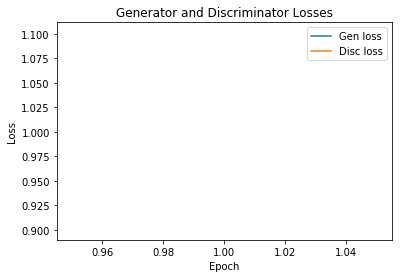

Time taken for epoch 1 is 104.48780131340027 sec


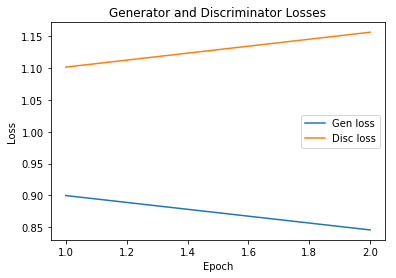

Time taken for epoch 2 is 101.24153184890747 sec


KeyboardInterrupt: 

In [22]:
%%time
train(train_dataset, EPOCHS)

**Restauración del último checkpoint**

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Resultados

Luego del entrenamiento, visualizamos los resultados obtenidos.

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
display_image(EPOCHS)

### GIF del proceso de entrenamiento

A continuación generamos un gif mostrando la evolución del generador sobre las imágenes de validación.

In [ ]:
with imageio.get_writer('mnist-inpainting.gif', mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)
    
# this is required in order to display the gif inside the notebook
os.system('cp mnist-inpainting.gif mnist-inpainting.gif.png')

In [ ]:
display.Image(filename="mnist-inpainting.gif.png")